In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_train_val_ap_ars, get_ap_ar_for_train_val
from datetime import datetime
from utils.coco_utils import get_cocos
from utils.save import get_data_from_metric_logger

from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders
from models.load import get_trained_model

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from utils.constants import full_iou_thrs
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
import torch.optim as optim
from models.dynamic_loss import DynamicWeightedLoss

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
from enum import Enum

class TrainedModels(Enum):
    # without_clinical = "val_ar_0_5377_ap_0_2981_test_ar_0_4515_ap_0_2716_epoch30_WithoutClincal_05-02-2022 12-32-56_without_clinical"

    # # without_clinical_final = "val_ar_0_5053_ap_0_2754_test_ar_0_4265_ap_0_2605_epoch100_WithoutClincal_05-02-2022 14-17-08_without_clinical"
    
    # ## original one.
    # with_clinical = "val_ar_0_7430_ap_0_5567_test_ar_0_7974_ap_0_5392_epoch29_WithClincal_05-02-2022 17-07-17_with_clinical"

    # ## smaller lr=1e-4
    # with_clinical_lr4 = "val_ar_0_6977_ap_0_4386_test_ar_0_7352_ap_0_4241_epoch59_WithClincal_05-01-2022 18-58-42_ov_13"

    # ## smaller lr=1e-3
    # with_clinical_lr3 = "val_ar_0_7641_ap_0_4498_test_ar_0_7120_ap_0_4252_epoch81_WithClincal_05-01-2022 16-52-32_ov_12"

    # # with_clinical_final = "val_ar_0_7269_ap_0_4601_test_ar_0_6710_ap_0_4286_epoch100_WithClincal_05-02-2022 19-03-30_with_clinical"

    # started_overfitting = "val_ar_0_8077_ap_0_6358_test_ar_0_7743_ap_0_6053_epoch100_WithClincal_05-14-2022 17-13-50_with_clinical_residule_add"

    continue_training = "val_ar_0_4380_ap_0_2588_test_ar_0_3989_ap_0_1968_epoch45_WithoutClincal_05-17-2022 23-16-57_CXR"


In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
iou_thrs = np.array([0.5])
use_iobb = True

train_more_models = [
    TrainedModels.continue_training
]

labels_cols = DEFAULT_REFLACX_LABEL_COLS

target_epoch = 200

# need to create a list for storing the namimg.
train_infos = []

In [6]:
for select_model in train_more_models:

    # load the model.
    model, train_info, optimizer = get_trained_model(
        select_model,
        labels_cols,
        device,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.train()
    
    # dynamic_loss_weight = None
    dynamic_loss_weight = DynamicWeightedLoss()
    dynamic_loss_weight.to(device)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    
    print_params_setup(model)
    model_setup = train_info.model_setup

    iou_types = get_iou_types(model, model_setup)

    if not optimizer:
        optimizer = get_optimiser(params, model_setup)

    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    # build the dataset again.
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size
    )

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    # get current epoch.
    last_trainng_epoch = train_info.epoch

    num_epochs_to_run = target_epoch - last_trainng_epoch

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    for e in range(last_trainng_epoch, target_epoch):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
                    model=model,
                    optimizer=optimizer,
                    data_loader=train_dataloader,
                    device=device,
                    epoch=train_info.epoch,
                    print_freq=10,
                    iou_types=iou_types,
                    coco=train_coco,
                    score_thres=None,
                    evaluate_on_run=True,
                    params_dict=eval_params_dict,
                )

        train_info.train_data.append(get_data_from_metric_logger(train_loger))

        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_data.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        ### update the learning rate
        if train_info.epoch > model_setup.warmup_epochs:
            val_loss = train_info.val_data[-1]['loss']
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_train_val_ap_ars(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )

    val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ar,
        last_val_ap=val_ap,
        test_dataloader=test_dataloader,
        device=device,   
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
    )

    train_infos.append(train_info)

Load custom model
Using ResNet as backbone
Using pretrained backbone. resnet50
Not using pretrained MaksRCNN model.
Found optimizer for this model.
Using SGD as optimizer with lr=0.001


ValueError: loaded state dict contains a parameter group that doesn't match the size of optimizer's group

====================| Training Done, start testing! | [142] Epochs Training time: [3919] seconds, Avg time / Epoch: [27.598591549295776] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_9667_ap_0_6943_test_ar_0_8224_ap_0_6060_epoch12_WithClincal_05-14-2022 13-53-26_with_clinical_residule_add]====================
====================Best AR validation model has been saved to: [val_ar_0_9667_ap_0_6581_test_ar_0_8724_ap_0_5616_epoch10_WithClincal_05-14-2022 13-50-07_with_clinical_residule_add]====================
Evaluation:  [ 0/15]  eta: 0:00:13  loss: 0.3879 (0.3879)  loss_classifier: 0.3813 (0.3813)  loss_box_reg: 0.0066 (0.0066)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0000 (0.0000)  model_time: 0.1040 (0.1040)  evaluator_time: 0.0010 (0.0010)  time: 0.9092  data: 0.5541  max mem: 1171
Evaluation:  [14/15]  eta: 0:00:00  loss: 1.6482 (1.9019)  loss_classifier: 1.6470 (1.8986)  loss_box_reg: 0.0025 (0.0032)  loss_objec

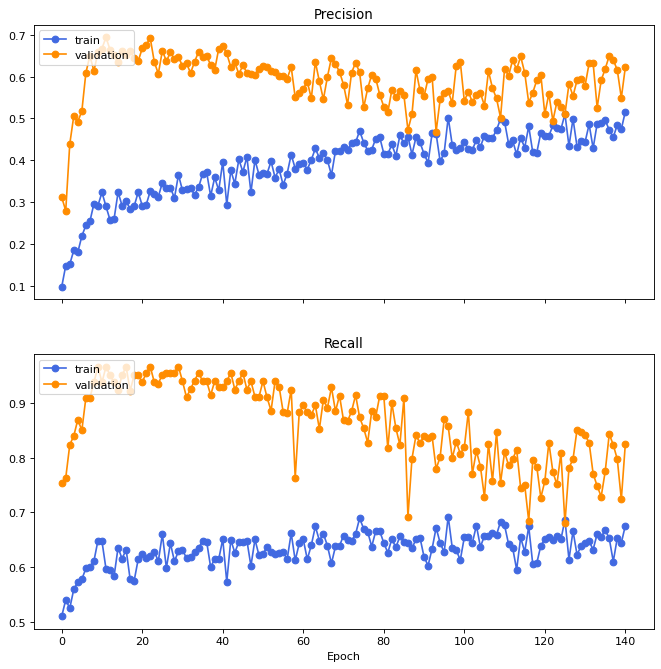

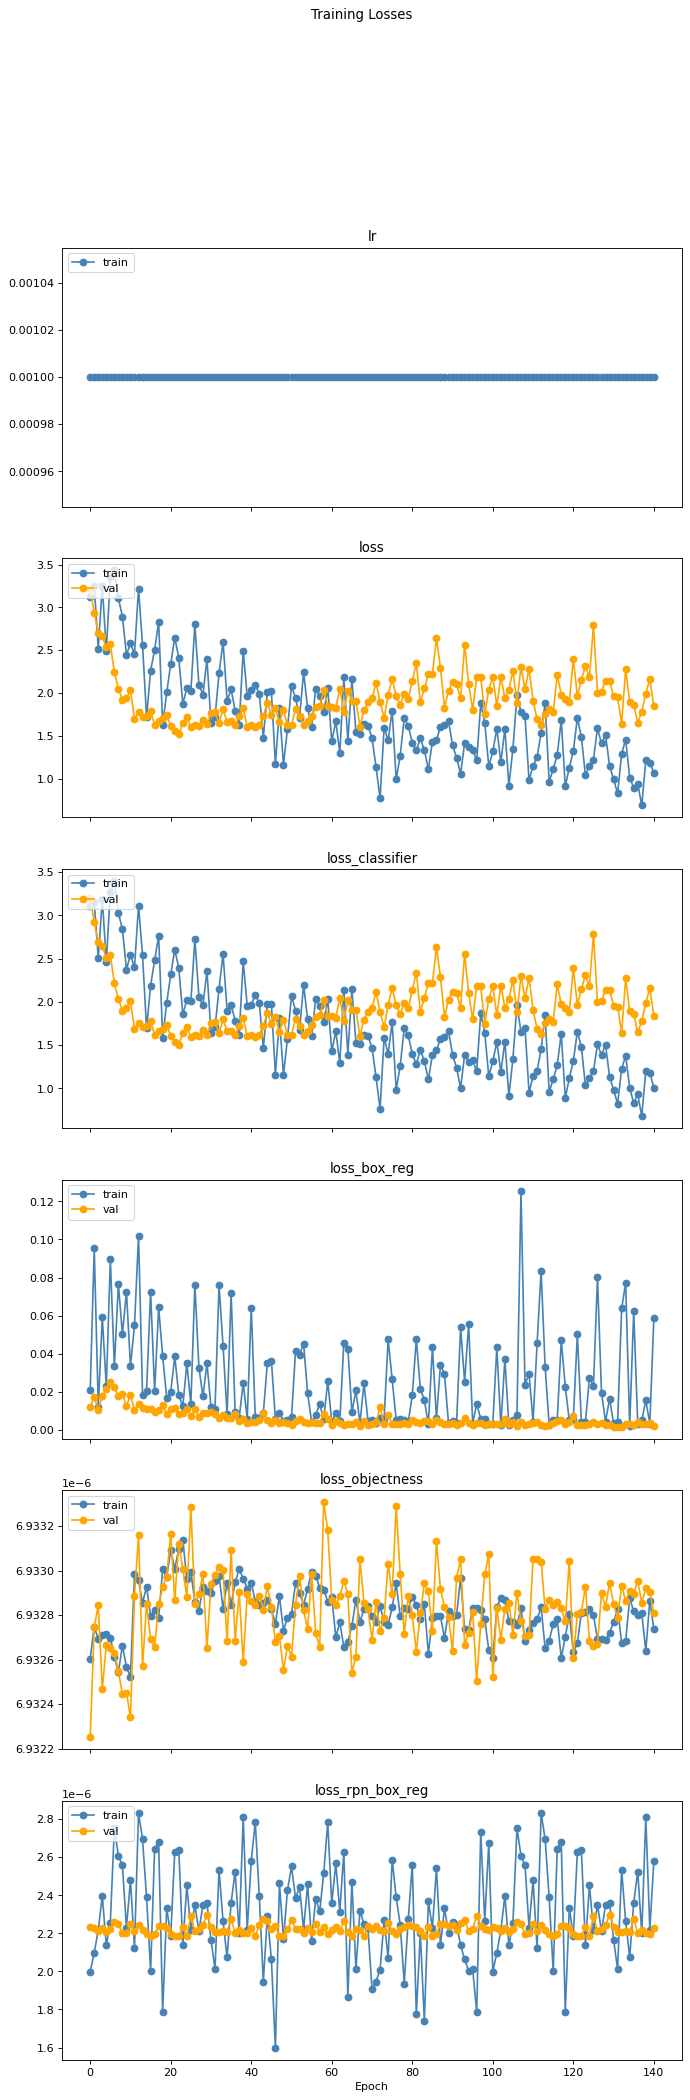

In [ ]:
from models.build import create_model_from_setup

val_ar, val_ap = get_ar_ap(train_info.last_val_evaluator)

train_info = end_train(
    train_info=train_info,
    model=model,
    optim=optimizer,
    eval_params_dict=eval_params_dict,
    last_val_ar=val_ar,
    last_val_ap=val_ap,
    test_dataloader=test_dataloader,
    device=device,   
    test_coco=test_coco,
    iou_types=iou_types,
    score_thres=None,
)

print(train_info)
model_setup = train_info.model_setup
model = create_model_from_setup(
    labels_cols,
    model_setup,
    rpn_nms_thresh=0.3,
    box_detections_per_img=10,
    box_nms_thresh=0.2,
    rpn_score_thresh=0.0,
    box_score_thresh=0.05,
)

print_params_setup(model)
plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
plot_losses(train_info.train_data, train_info.val_data)

========================================For Training [ov_12]========================================
ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='ov_12', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=0.001, pretrained=True, record_training_performance=True, dataset_mode='unified', image_size=256, backbone_out_channels=16, batch_size=4, warmup_epochs=0, lr_scheduler=None, reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=3, multiStepLR_milestones=[30, 50, 70, 90], multiStepLR_gamma=0.1, representation_size=32, mask_hidden_layers=256, using_fpn=False, use_mask=False, clinical_expand_dropout_rate=0, clinical_conv_dropout_rate=0, clinical_input_channels=32, clinical_num_len=9, clinical_conv_channels=32, fuse_conv_channels=32, fuse_dropout_rate=0, box_head_dropout_rate=0, fuse_depth=4)

Best AP validation model has been saved to: [val_ar_0_7222_

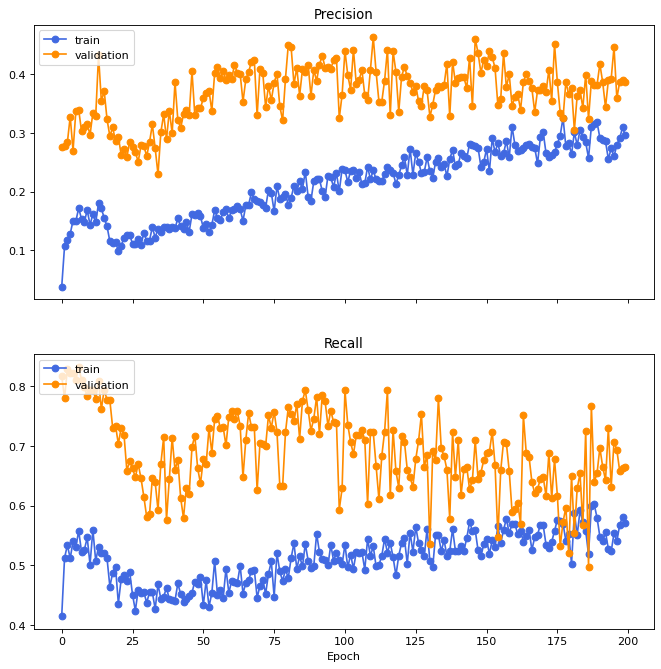

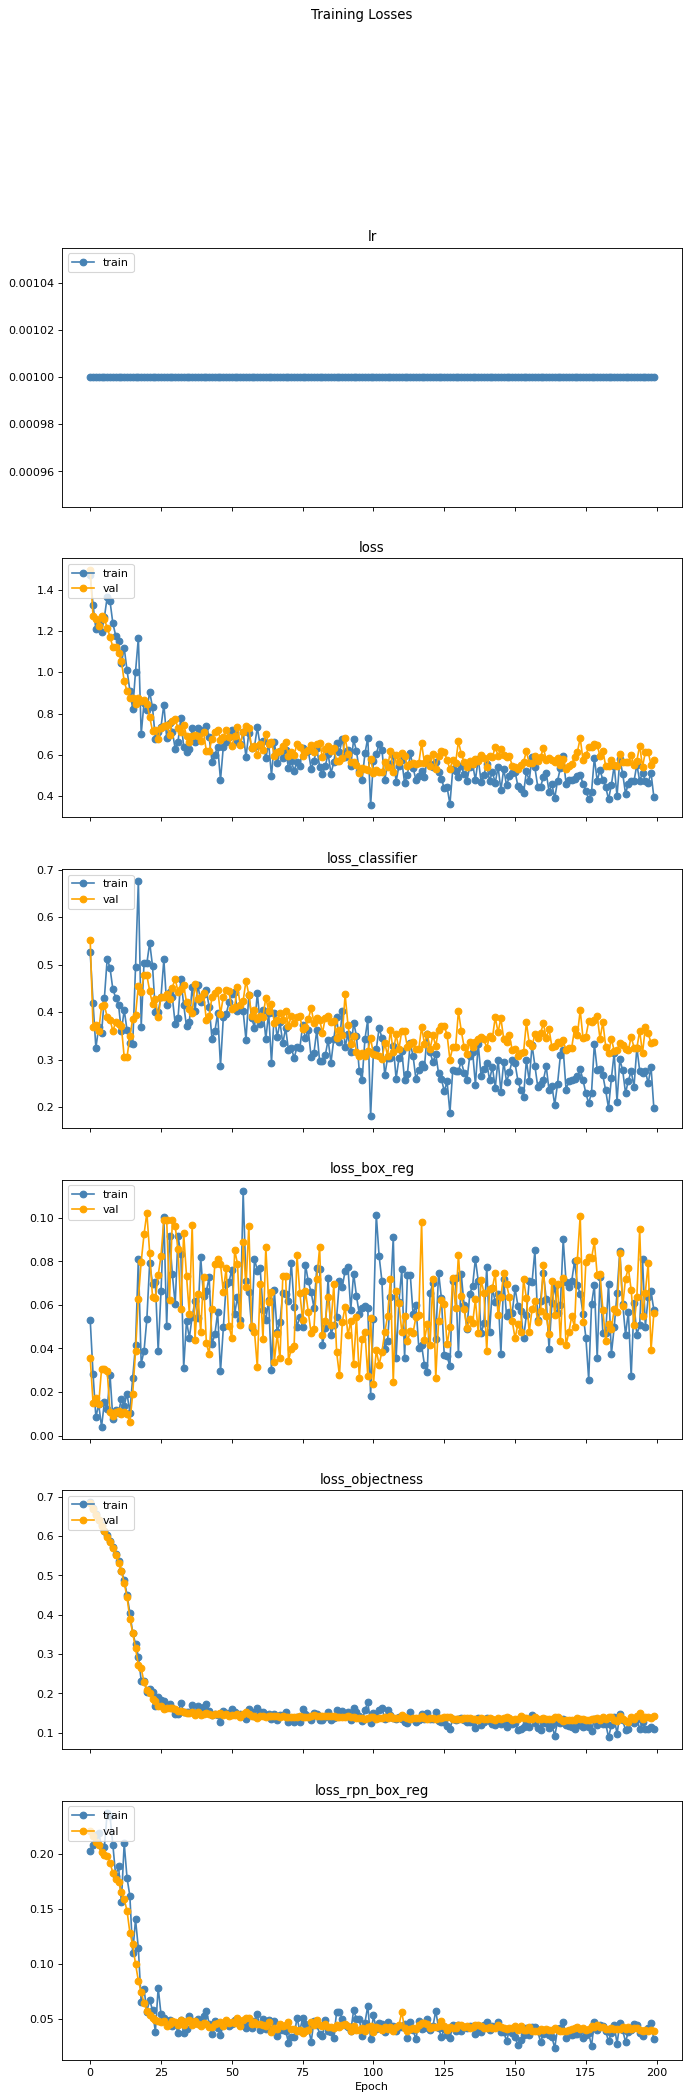

In [ ]:


for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_model_from_setup(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    plot_train_val_ap_ars(train_info.train_ap_ars, train_info.val_ap_ars)
    plot_losses(train_info.train_data, train_info.val_data)



In [ ]:
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained]

# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained]